In [79]:
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
from scipy import ndimage
%matplotlib inline

In [80]:
#Global object used to create local blok representations within a players 'hand'


x = np.array([[1,1]])
print len(x.shape)#[0]

2


In [81]:
class Blok:
    
    _pieces = {
    'L5' : [[1,1,1,1],[0,0,0,1]],
    'Y'  : [[1,1,1,1],[0,1,0,0]],
    'N'  : [[1,1,1,1],[0,0,1,1]],
    'U'  : [[1,1],[1,0],[1,1]],
    'V3' : [[1,0],[1,1]],
    'V5' : [[1,0,0],[1,0,0],[1,1,1]],
    'Z5' : [[1,1,0],[0,1,0],[0,1,1]],
    'X'  : [[0,1,0],[1,1,1],[0,1,0]],
    'T5' : [[1,1,1],[0,1,0],[0,1,0]],
    'W'  : [[1,0,0],[1,1,0],[0,1,1]],
    'P'  : [[1,1],[1,1],[1,0]],
    'F'  : [[0,1,1],[1,1,0],[0,1,0]],
    'O' : [[1,1],[1,1]],
    'L4' : [[1,1,1],[0,0,1]],
    'T4' : [[1,1,1],[0,1,0]],
    'Z4' : [[1,1,0],[0,1,1]],
    'I2' : [[1,1]],
    'I3' : [[1,1,1]],
    'I4' : [[1,1,1,1]],
    'I5' : [[1,1,1,1,1]]
    }
    
    def __init__(self, blockName):
        self.name = blockName
        self.kernel = np.array(Blok._pieces[blockName])
        
    def __cmp__(self, other):
        #Magic method for comparison. Lets block class compare itself to Bloks and strings.
        #Can define more specific comparisons, but since I'm lazy, blocks are ALWAYS less than 
        #other python objects not in (blok, string)
        if type(other) is str:
            if other == self.name:
                return 0
            else:
                return -1
        elif type(other) is Blok:
            if other.name == self.name:
                return 0
            else:
                return -1
        else:
            return -1
            
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name
        #return self.name
        
    def show(self, verbose=False):
        if verbose:
            plt.figure(self.name)
            colors = matplotlib.colors.ListedColormap(['gray','red','yellow','blue','green'])
    #         if len(self.kernel.shape) > 1:
            plt.pcolormesh(range(self.kernel.shape[1]+1),range(self.kernel.shape[0]+1),self.kernel,edgecolors='black',cmap=colors)
    #         else:
    #             plt.pcolormesh(range(2),range(self.kernel.shape[0]+1),self.kernel,edgecolors='black',cmap=colors)
            print "[", self.name
            plt.show()
            print "]"
            plt.clf()
        else:
            print "[", self.name, "]"

    def rotate(self, iterate=1):
        for i in range(iterate):
            self.kernel = np.rot90(self.kernel)
    
    def flip(self):
        self.kernel = np.transpose(self.kernel)

In [82]:
class Player:
    def __init__(self, playerName, playerID):
        self.name = playerName
        self.pID = playerID
        #On initalization, create a new list of blokx
        self.pieceDict = self.generatePieces()
        
    def generatePieces(self):
        #I'm so sorry... It's a dictionary of BlokName: BlokObject 
        retDict = {}
        for piece in Blok._pieces.keys():
            retDict[piece] = Blok(piece)
            #retList.append(Blok(piece))
        return retDict
        
    def playPiece(self, piece):
        if piece in self.pieceDict:
            retPiece = self.pieceDict.pop(piece, None)
            return True, retPiece.kernel
        else:
            print(str(self.name) + ' has no piece \'' + str(piece) + '\'')
            return False, None

    def showHand(self, verbose=False):
        for piece in self.pieceDict.values():
            piece.show(verbose=verbose)
    
    #Huehuehue I love magic methods
    def __len__(self):
        return len(self.pieceDict.keys())
    
#     def __missing__(self, key):
#         print "Piece ", key, " is not in ", self.name, "'s hand."
#         return False

    def __getitem__(self, key):
        # if key is of invalid type or value, the list values will raise the error
        return self.pieceDict[key]

    def __setitem__(self, key, value):
        self.pieceDict[key] = value

    def __delitem__(self, key):
        del self.pieceDict[key]



In [83]:
##Testing Block, not production code
daniel = Player('Daniel',1)
print daniel.showHand()
#daniel.playPiece('Z4')
#print daniel.showHand(verbose=not True)
#daniel.playPiece('foo')
#print daniel.pieceDict['I5']
#print daniel['I5']

[ T5 ]
[ Y ]
[ F ]
[ T4 ]
[ I2 ]
[ I5 ]
[ I4 ]
[ O ]
[ N ]
[ P ]
[ L4 ]
[ V3 ]
[ U ]
[ V5 ]
[ W ]
[ Z5 ]
[ L5 ]
[ X ]
[ Z4 ]
[ I3 ]
None


In [104]:
class Board:
    def __init__(self, **kwargs):
        self.boardState = kwargs.get('BoardState', np.zeros((20,20)))
        #self.boardState.index = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t']

    def checkLegality(self, player, piece, (x,y)):
        kernel = Blok(piece).kernel
        width, height = kernel.shape[0], kernel.shape[1]
        #Check that the player is playing within the bounds of the board
        if ((x+width>self.boardState.shape[0]) or (y+height>self.boardState.shape[1]))\
            or ((x<0) or (y<0)):
                raise IndexError('There isn\'t enough board for that harebrained bullshit.')
        #Check that the player is not playing on top of another piece
        if (np.amax(self.boardState[x:x+kernel.shape[0],y:y+kernel.shape[1]] + kernel) > 1):
            raise ValueError('Two pieces may not overlap.')
        #Check that the player is not playing against the edge of another of their pieces
        padded = np.pad(kernel,1,'constant')
        dilation = sp.ndimage.morphology.binary_dilation(padded).astype('int')
        edgeMask = dilation - padded
        boardSlice = np.pad(self.boardState,1,'constant')[x:x+width+2,y:y+height+2]
        if(np.any(np.equal(boardSlice,player.pID*edgeMask)*edgeMask)):
            raise ValueError('Two like-colored pieces cannot touch edges.')
        #Check that the player is playing catercorner to another of their pieces
        cornerKernel = [[0,1,0],[1,-4,1],[0,1,0]]
        cornerMask = sp.signal.convolve2d(dilation, cornerKernel)[1:-1,1:-1].clip(min=0,max=1)
        if(not np.any(np.equal(boardSlice,player.pID*cornerMask)*cornerMask)):
            if not((x==0 and y==0)or(x==0 and y+height==20)\
                or(x+width==20 and y==0)or(x+width==20 and y+height==20)):
                    raise ValueError('Pieces must touch at least one like-colored corner.')
            
        
    def addPiece(self, player, piece, (x,y),check_legal=True):
        #kernel = np.array(pieces[piece])*player.pID
        if(check_legal): self.checkLegality(player, piece, (x,y))
        hasPiece, kernel = player.playPiece(piece)
        if hasPiece:
            kernel = kernel * player.pID
            #One is welcome to imagine an implementation that uses the Point class
            #One is welcome to imagine many things
            #One is the loneliest number
            self.boardState[x:x+kernel.shape[0],y:y+kernel.shape[1]] = kernel
        else:
            print('Matt please teach me how to create exceptions in python')
            
    def printBoard(self):
        colors = matplotlib.colors.ListedColormap(['gray','red','yellow','blue','green']) #working sort of kind of as intended
        plt.figure(figsize=(10,10))
        plt.pcolormesh(range(21),range(21),game1.boardState,edgecolors='black',cmap=colors)
        labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t']
        plt.xticks(range(1,21),labels)
        plt.yticks(range(1,21))
        plt.show()
            

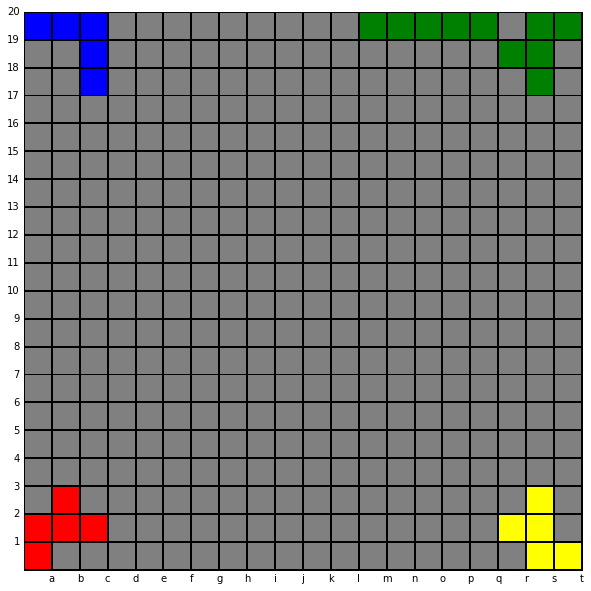

In [110]:
##Testing block, not production code (lol, "production," "code")
daniel = Player('Daniel', 1)
matt = Player('Matt', 2)
anthony = Player('Anthony', 3)
jay = Player('Jay Lee', 4)
game1 = Board()

daniel['F'].rotate()
game1.addPiece(daniel, 'F', (0, 0))
#print game1.boardState
anthony['V5'].rotate()
game1.addPiece(anthony, 'V5', (17, 0))

# matt['F'].rotate()
# matt['F'].flip()
game1.addPiece(matt, 'F', (0, 17))

jay['F'].flip()
jay['F'].rotate()
game1.addPiece(jay, 'F', (17, 17))
game1.addPiece(jay, 'I5', (19,12), check_legal=True)
#game1.addPiece(matt, 'O', (5,6))

game1.printBoard()


???? fuck it for now